In [1]:
# cargamos librerías necesarias
import numpy  as np  
import pandas as pd

import matplotlib.pyplot as plt # para dibujar
%matplotlib inline

Funciones útiles para calcular prestaciones

In [2]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

In [3]:
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel()
    
    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ',acc)
    print('SEN: ',sen)
    print('ESP: ',esp)
    print('PPV: ',ppv)
    print('FSC: ',fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1,6],[1,1],color=(0.6,0.6,0.6),linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

# Problema de clasificación (censo)

## 1. Cargar datos

In [4]:
census_data = pd.read_csv("./census.csv",sep=',',decimal='.') # cargamos fichero

print('Dimensiones: (%i,%i)' %census_data.shape)
census_data.head(5)                       

Dimensiones: (45222,14)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [5]:
census_data['income'].value_counts()/census_data.shape[0]

<=50K    0.752156
>50K     0.247844
Name: income, dtype: float64

Nuestra variable target es **income**, vemos que puede tener dos posibles valores y las muestras que tenemos se dividen un 75% en "<=50K" y el 25% en ">50K" por lo que está algo desbalanceado

Vemos que hay muchas variables categóricas y algunas numéricas

In [6]:
np.sum(census_data.isnull())

age                0
workclass          0
education_level    0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

Todos los valores de todas las variables están informadas, por lo que no será necesario tomar ninguna acción al respecto


In [7]:
census_data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


Viendo las variables numéricas sin tener en cuenta a aque clase pertenecen, observamos que la mayoria de valores tanto de *capital-gain* como de *capital-loss* son 0,pero tienen unos máximos muy elevados.

Por otro lado solo el 25% de la gente pasa de las 45 horas de trabajo semanales y la mayoria trabaja unas 40. La edad media está sobre los 38 años y pocas muestras pasan de los 47

Creamos los histogramas normalizados de cada clase para ver si existe alguna separación evidente

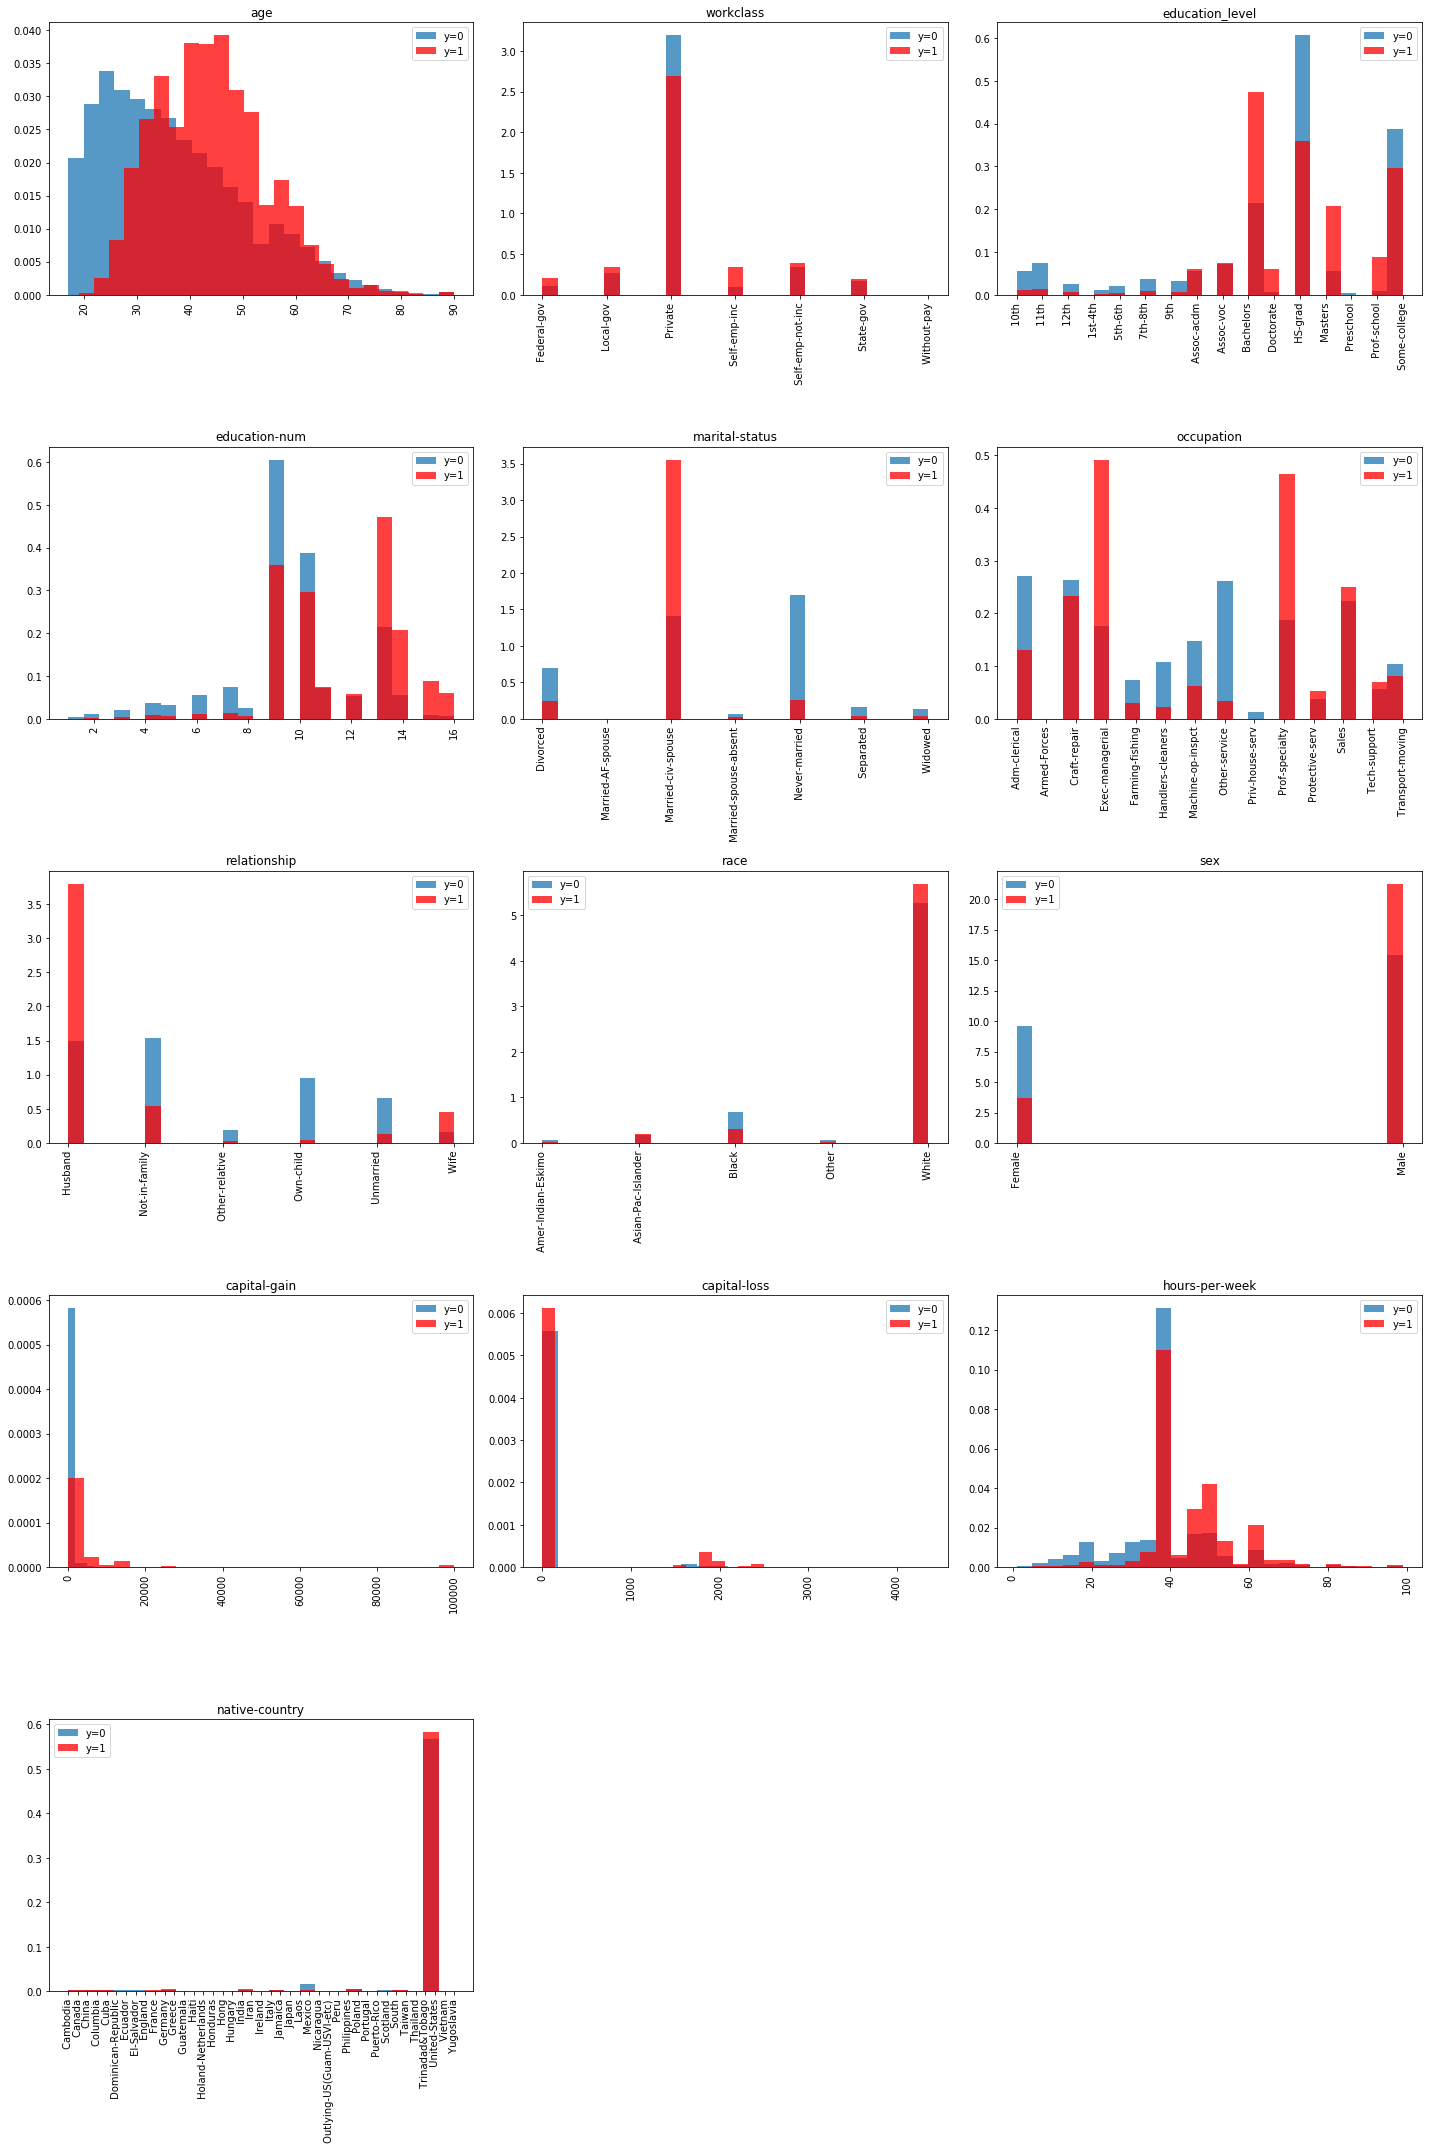

In [8]:

plt.figure(figsize=(20,30))

idx_0 =  census_data['income'] == "<=50K"
idx_1 =  census_data['income'] == ">50K"

for i,feature in enumerate(census_data.columns.drop(['income'])):
    plt.subplot(5,3,i+1)   
    plt.xticks(rotation=90)
    plt.hist(census_data.loc[idx_0,feature],normed=1, alpha=0.75,label='y=0',bins=25)
    plt.hist(census_data.loc[idx_1,feature],normed=1, facecolor='red', alpha=0.75,label='y=1',bins=25)
    plt.legend()
    plt.title(feature)

plt.tight_layout()

A simple vista sólo podriamos decir que para la población con una edad inferior a 20 años sus ingresos son inferiores a 50000. 
Por lo demás vemos que para todas las variables, las clases están muy solapadas con lo que serrá difícil hacer una buena separación.

### Preprocesamiento de variables
Las variables **workclass, marital-status, occupation, relationship, race y native-country** no tienen un orden que tenga un significado, por lo que transformarlas en números con el *LabelEncoder* podría no ser lo mas adecuado sobre todo para algoritmos que se basen en distancias como el Knn. 

Una posible solución seria utilizar *OneHotEncoder* pero esto haría aumentar mucho la dimensionalidad de los datos y por tanto la complejidad de los modelos.
Por este motivo, por el momento dejamos la transformación con el *LabelEncoder*.

Para la variable **sex** no afecta ya que es binaria

El caso de **education-level** se supone que si tiene un orden que podría tener relevancia, pero como no conzco ese orden dejamos la asignación numérica al algoritmo del *LabelEncoder*

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer

le = LabelEncoder()

census_data['workclass'] = le.fit_transform(census_data['workclass'])
census_data['education_level'] = le.fit_transform(census_data['education_level'])
census_data['marital-status'] = le.fit_transform(census_data['marital-status'])
census_data['occupation'] = le.fit_transform(census_data['occupation'])
census_data['relationship'] = le.fit_transform(census_data['relationship'])
census_data['race'] = le.fit_transform(census_data['race'])                 
census_data['sex'] = le.fit_transform(census_data['sex'])
census_data['native-country'] = le.fit_transform(census_data['native-country'])
                                               
census_data['income'] = le.fit_transform(census_data['income'])

print('N, D: ',census_data.shape)
census_data.head()

N, D:  (45222, 14)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,5,9,13.0,4,0,1,4,1,2174.0,0.0,40.0,38,0
1,50,4,9,13.0,2,3,0,4,1,0.0,0.0,13.0,38,0
2,38,2,11,9.0,0,5,1,4,1,0.0,0.0,40.0,38,0
3,53,2,1,7.0,2,5,0,2,1,0.0,0.0,40.0,38,0
4,28,2,9,13.0,2,9,5,2,0,0.0,0.0,40.0,4,0


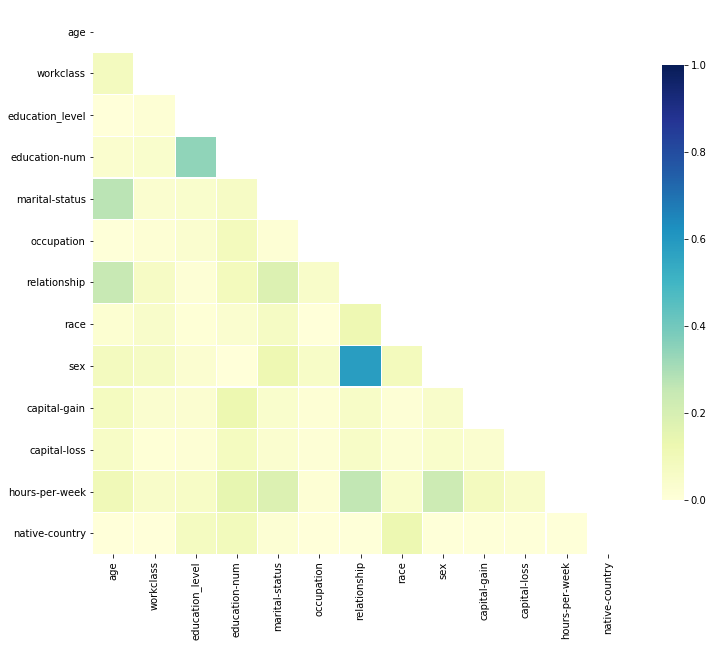

In [10]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(census_data.drop(['income'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

No se aprecian pares de variables correlacionadas (las que mas entre *relationship* y *sex*) por lo que a priori todas las variables aportarian información de forma independiente

### Creación de conjuntos de entrenamiento y test

Al estar los datos algo desbalanceados respecto del target, haremos el split usando estratificación para que se quede la misma proporcion de cada clase en train y en test

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# preparamos los datos

#columns_to_drop.append('income')
features = census_data.columns.drop('income')

X = census_data[features].as_matrix()
y = census_data['income'].as_matrix()


# Dividimos las muestras en train (75%) y test (25%)
# Estratificamos sobre la variable target para que tanto en train como en test
# haya la misma proporición de cada clase
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state=0)


# Realizamos un escalado para que todas las variables esten en un mismo rango
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test  = scaler.transform(X_test)

print('Datos train: ', Xs_train.shape)
print('Datos test:  ', Xs_test.shape)

print('Propocion train:%0.3f'%np.mean(y_train))
print('Propocion test: %0.3f'%np.mean(y_test))

Datos train:  (33916, 13)
Datos test:   (11306, 13)
Propocion train:0.248
Propocion test: 0.248


Hay la misma proporción de ingresos tanto en train como en test (24.8%)

## Creación y evaluación de modelos

Empezaremos por ver las prestaciones de un modelo simple para luego ir a modelos mas complejos si es necesario

In [12]:
sum(y_train==0)/y_train.size

0.7521523764594882

El 75% de las muestras de training son de clase 0 por lo que si nuestro clasificador siempre devolviese la clase 0, acertaria en un 75% de las veces. Nuestro objetivo pues es mejorar este 75%

#### KNN

Al tener tantas variables categóricas entiendo que un algoritmo basado en distancias no tendrá buen rendimiento, de todas formas voy a crear un modelo basado en Knn para probar

best mean cross-validation score: 0.639
best parameters: {'n_neighbors': 23}


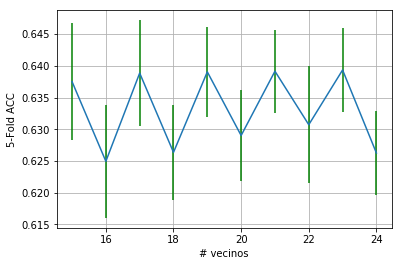

acc (test): 0.64


In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

nVecinos = np.arange(15,25, 1)
param_grid = {'n_neighbors': nVecinos }
grid = GridSearchCV(KNeighborsClassifier(), scoring= 'f1', param_grid=param_grid, cv = 5)
grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score']) 
stdvalues = np.array(grid.cv_results_['std_test_score'])
#plt.plot(nVecinos,scores,'-o')
plt.errorbar(nVecinos, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('# vecinos')
plt.ylabel('5-Fold ACC')
plt.grid()
plt.show()

print("acc (test): {:.2f}".format(grid.score(Xs_test, y_test)))

La mejor opción encontrada es con 23 vecinos.

Veamos que prestaciones tiene (en test)

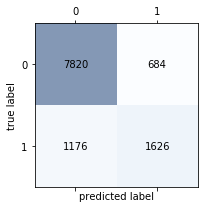

ACC:  0.8354855828763489
SEN:  0.5802997858672377
ESP:  0.9195672624647225
PPV:  0.7038961038961039
FSC:  0.636150234741784


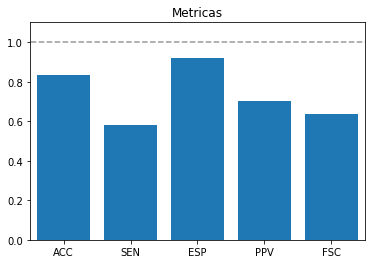

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
#
knn = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors']).fit(Xs_train,y_train)
y_pred = knn.predict(Xs_test)

confmat = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(confmat)
calcula_metricas(confmat)

Tenemos unos aciertos bastante altos (ACC: 83%) aunque la relación sensibilidad ppv es baja (FSC: 63%).Por otro lado la Especificidad es alta debido a que la mayor parte de las veces predecimos la clase 0

## Regresión logisitca

Veamos el comportamiento con una regresión logística simple

In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1,random_state=0, class_weight='balanced').fit(Xs_train,y_train)
y_pred = lr.predict(Xs_train)

Comportamiento en Train

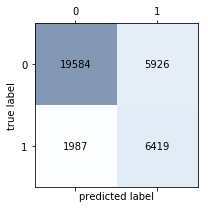

ACC:  0.7666882887132916
SEN:  0.7636212229359981
ESP:  0.7676989415915327
PPV:  0.519967598217902
FSC:  0.618668979808202


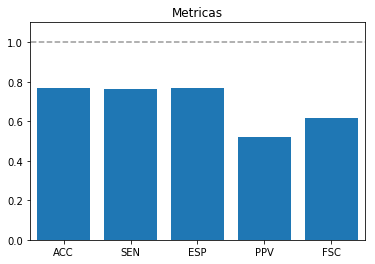

In [16]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_train,y_pred)
plot_confusion_matrix(confmat)
calcula_metricas(confmat)

Comportamiento en Test

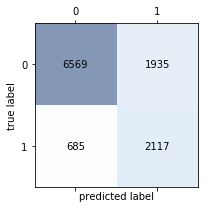

ACC:  0.7682646382451795
SEN:  0.7555317630264097
ESP:  0.7724600188146754
PPV:  0.5224580454096742
FSC:  0.6177414648380507


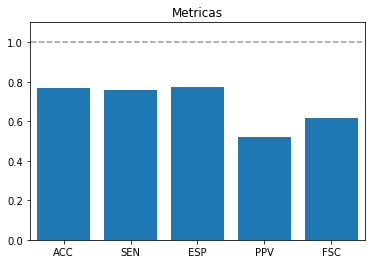

In [17]:
y_pred_test = lr.predict(Xs_test)

confmat_test = confusion_matrix(y_test,y_pred_test)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

Con este modelo las prestaciones son sensiblemente peores que con el Knn

Si vemos las distribución de las probabilidades de cada clase, quizá veamos un umbral de corte mejor

(array([0.11369672, 0.28974326, 0.52813961, 0.83622106, 0.85822687,
        1.07461741, 1.29100795, 1.30567849, 1.58075121, 2.39863408]),
 array([0.02692656, 0.12423391, 0.22154125, 0.31884859, 0.41615594,
        0.51346328, 0.61077063, 0.70807797, 0.80538531, 0.90269266,
        1.        ]),
 <a list of 10 Patch objects>)

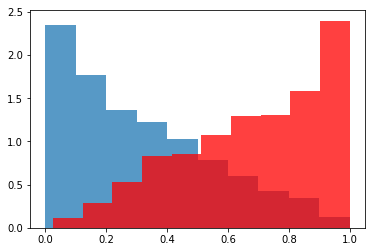

In [18]:
# probabilidad de pertenecer a cada clase en el conjunto de test
y_prob = lr.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

plt.hist(y_prob[idx_0],normed=1,label='Y=0', alpha=0.75)
plt.hist(y_prob[idx_1],normed=1,label='Y=1',facecolor='red', alpha=0.75)

El umbral de corte que podríamos escoger de forma intuitiva es 0.5 que es el que ya tiene por defecto el algoritmo. 

De todas formas vamos a comprobarlo

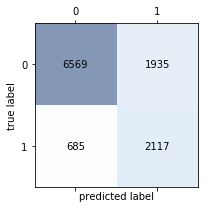

ACC:  0.7682646382451795
SEN:  0.7555317630264097
ESP:  0.7724600188146754
PPV:  0.5224580454096742
FSC:  0.6177414648380507


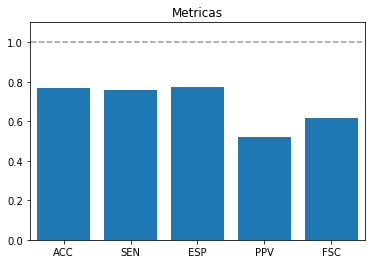

In [19]:
y_pred2 = np.where(y_prob>0.5,1,0)
confmat_test = confusion_matrix(y_test,y_pred2)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

El resultado es exactamente el mismo.

Si miramos las probabilidades de cada clase sin normalizar, vemos que hay muchas mas muestras de la clase 0 y si cortamos por 0.5 predecimos mejor la clase 0 por lo que la ESPecificidad es mas alta (0.77)


(array([ 31.,  79., 144., 228., 234., 293., 352., 356., 431., 654.]),
 array([0.02692656, 0.12423391, 0.22154125, 0.31884859, 0.41615594,
        0.51346328, 0.61077063, 0.70807797, 0.80538531, 0.90269266,
        1.        ]),
 <a list of 10 Patch objects>)

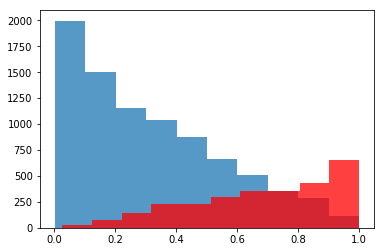

In [20]:
plt.hist(y_prob[idx_0],normed=0,label='Y=0', alpha=0.75)
plt.hist(y_prob[idx_1],normed=0,label='Y=1',facecolor='red', alpha=0.75)

Veamos que pinta tiene la curva ROC

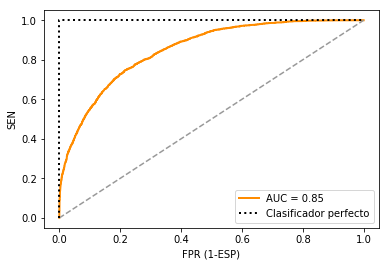

In [21]:
from sklearn.metrics import roc_curve, auc

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

La curva ROC no está mal, pero tanto el ACCuracy como el FSC son bajos por lo que hay que mejorar el modelo. 

Siguiendo con la regresión logística, buscamos el valor óptimo de C

best mean cross-validation score: 0.619
best parameters: {'C': 0.03162277660168379}


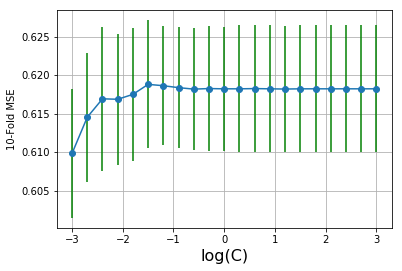

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

vectorC = np.logspace(-3,3,21)
param_grid = {'C': vectorC }

grid = GridSearchCV(LogisticRegression(random_state=0, class_weight='balanced'),
                    scoring='f1', 
                    param_grid=param_grid, 
                    cv = 10)

grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(vectorC),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(C)',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.grid()
plt.show()

Esta curva no es nada buena ya que tenemos mucha variabilidad en el error. Las prestaciones para el valor óptimo de C no diferirán mucho de las de C=1

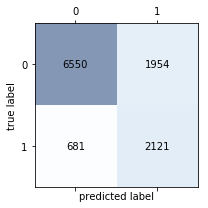

ACC:  0.7669379090748275
SEN:  0.7569593147751607
ESP:  0.7702257761053621
PPV:  0.5204907975460122
FSC:  0.6168387378217246


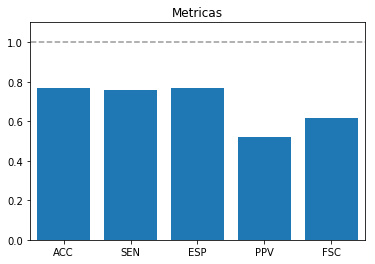

In [25]:
lr = LogisticRegression(random_state=0,
                        C = grid.best_params_['C'],
                        class_weight='balanced').fit(Xs_train,y_train)
y_pred_test = lr.predict(Xs_test)

confmat_test = confusion_matrix(y_test,y_pred_test)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

Curiosamente no somos capaces de mejorar en FSC (FSC:0.616 frente a 0.617 con C=1).
De todas formas sigue siendo ligeramente inferior al Knn (FSC: 0.63)

## Árboles de decisión

Estudiemos si con un árbol de decisión podemos mejorar los resultados. Para ello buscamos cual es la profundidad óptima para un mejor F1

best mean cross-validation score: 0.678
best parameters: {'max_depth': 8}


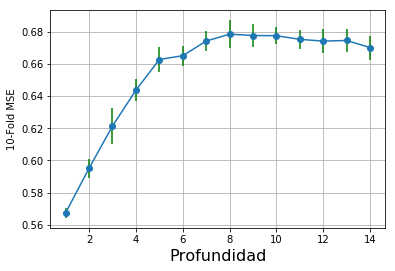

In [27]:
from sklearn.tree import DecisionTreeClassifier

maxDepth = range(1,15)
param_grid = {'max_depth': maxDepth }

grid = GridSearchCV(DecisionTreeClassifier(random_state=0,class_weight='balanced'),
                    scoring='f1', 
                    param_grid=param_grid, 
                    cv = 5)

grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(maxDepth,scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('Profundidad',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.grid()
plt.show()

Encontramos una profundidad óptima de 8

#### Veamos las prestaciones

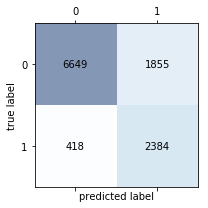

ACC:  0.7989563063859897
SEN:  0.8508208422555318
ESP:  0.7818673565380997
PPV:  0.5623967916961548
FSC:  0.6771765374236614


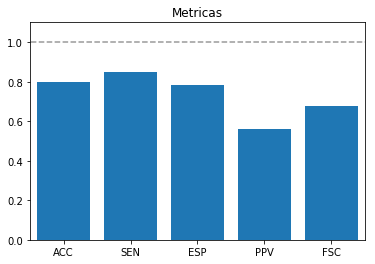

In [28]:
depthOpt = grid.best_params_['max_depth']

tree = DecisionTreeClassifier(random_state=0,
                              max_depth = depthOpt,
                              class_weight='balanced').fit(Xs_train,y_train)

y_pred = tree.predict(Xs_test)

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

(array([ 69.,  88.,  19., 113., 129., 138., 609., 152., 747., 738.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

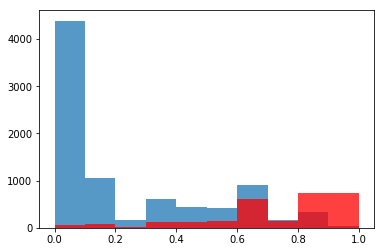

In [32]:
# probabilidad de pertenecer a cada clase en el conjunto de test
y_prob = tree.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

plt.hist(y_prob[idx_0],normed=0,label='Y=0', alpha=0.75)
plt.hist(y_prob[idx_1],normed=0,label='Y=1',facecolor='red', alpha=0.75)

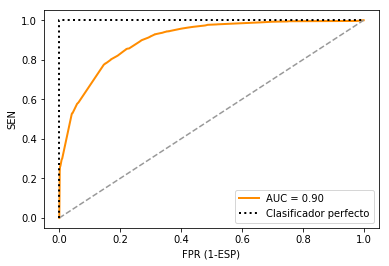

In [34]:
from sklearn.metrics import roc_curve, auc

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

Tanto el AUC:0.90 como el FSC:0.67 son ligeramente mejores que la regresión logística AUC:0.85 FSC:0.61 y ya superamos el FSC:0.63 del Knn aunque no su ACC ni su PPV

#### Random Forest
Probemos con random forest

best mean cross-validation score: 0.708
best parameters: {'max_depth': 18}


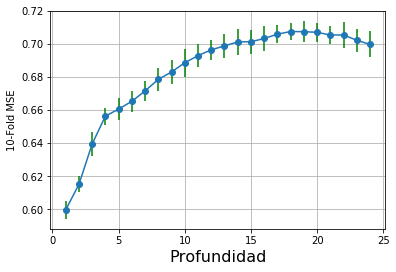

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# grid search
maxDepth   = range(1,25)
param_grid = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(random_state=0,
                                           n_estimators=200,
                                           max_features='sqrt',
                                           class_weight='balanced'),
                    scoring='f1', 
                    param_grid=param_grid, 
                    cv = 5)

grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(maxDepth,scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('Profundidad',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.grid()
plt.show()

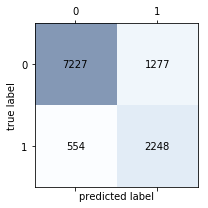

ACC:  0.8380505926056961
SEN:  0.8022840827980015
ESP:  0.8498353715898401
PPV:  0.6377304964539007
FSC:  0.7106053421842895


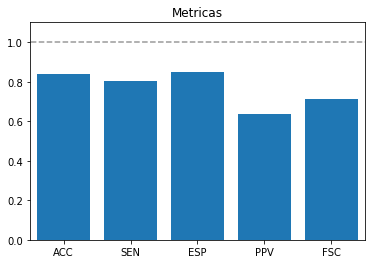

In [16]:
from sklearn.metrics import confusion_matrix

depthOpt = grid.best_params_['max_depth']

rf = RandomForestClassifier(random_state=0,
                            max_depth = depthOpt,
                            n_estimators=200,
                            max_features='sqrt',
                            class_weight='balanced').fit(Xs_train,y_train)
y_pred = rf.predict(Xs_test)

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

Aumentamos tanto el FSC:0.71 como el ACCuracy:0.83, por lo que este modelo es mejor que los anteriores

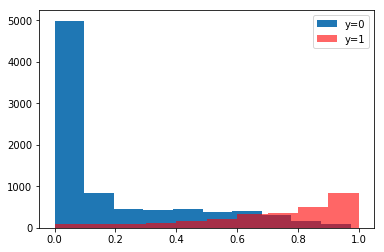

In [17]:
y_prob = rf.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

# your code here
plt.hist(y_prob[idx_0], normed = 0, label = 'y=0')
plt.hist(y_prob[idx_1], normed = 0, facecolor = 'r',alpha=0.6, label = 'y=1')
plt.legend(loc=1)
plt.show()

Seguimos sin tener una separación clara entre las clases. Hay muchas mas muestras de la clase 0 y con un umbral de 0.5 es mas "facil" acertar con esta clase, de ahí el tener la ESPecificidad tan elevada 0.85

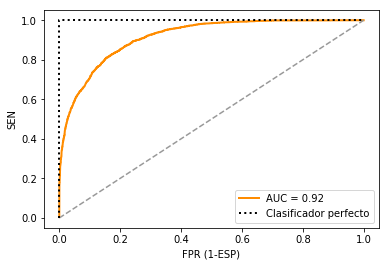

In [19]:
from sklearn.metrics import roc_curve, auc

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

La curva ROC nos muestra un AUC igual que en el caso de un solo árbol, pero con random forest las prestaciones son mejores

### boosted trees
Fijando una profundidad máxima de 2, iteramos sobre los dos parámetros principales para encontrar sus valores óptimos

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

Niterations = [175,200,300,400]
learningRate = [0.5,0.1,0.05,0.01]
# mantenemos max_depth estático: max_depth=2

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingClassifier(random_state=0, max_depth=2),
                    param_grid=param_grid,                     
                    cv = 5)
grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.870
best parameters: {'learning_rate': 0.5, 'n_estimators': 300}


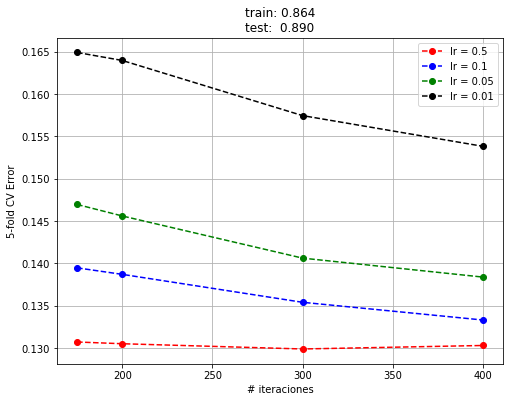

In [38]:
# calculamos métricas globales
bt = GradientBoostingClassifier(random_state=0, max_depth=2,learning_rate= 0.5, n_estimators= 300)
bt.fit(Xs_test,y_test)

plt.figure(figsize=(8,6))
error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

    
plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(Xs_train,y_train),bt.score(Xs_test,y_test)))
plt.grid()
plt.show()

Como vemos, la linea roja es la que indica un error menor teniendo su punto mínimo en 300 iteracinones.

Vamos a ver cuales son las prestaciones con estos parámetros (max_depth=2,learning_rate=0.1, n_estimators=300)

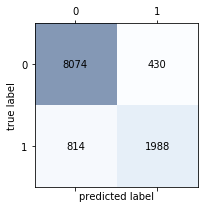

ACC:  0.8899699274721387
SEN:  0.7094932191291934
ESP:  0.9494355597365945
PPV:  0.8221670802315963
FSC:  0.7616858237547893


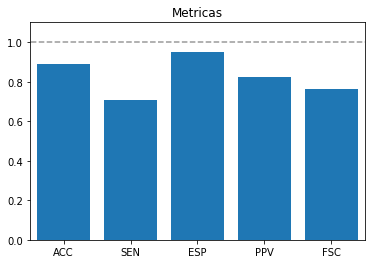

In [36]:
y_pred = bt.predict(Xs_test)

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

Conseguimos el mayor ratio de FSC:0.76 aunque ha bajado un poco la sensibilidad lo que implica que detectamos menos casos de la clase 1 a cambio de ser más precisos (PPV:0.82).

También vemos que el área bajo la curva ROC es de 0.95 que es la mejor de todas

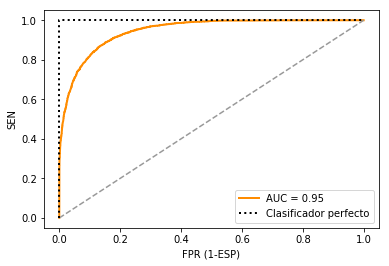

In [39]:
from sklearn.metrics import roc_curve, auc

y_prob = bt.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

Veamos la importancia de las variables de manera individual

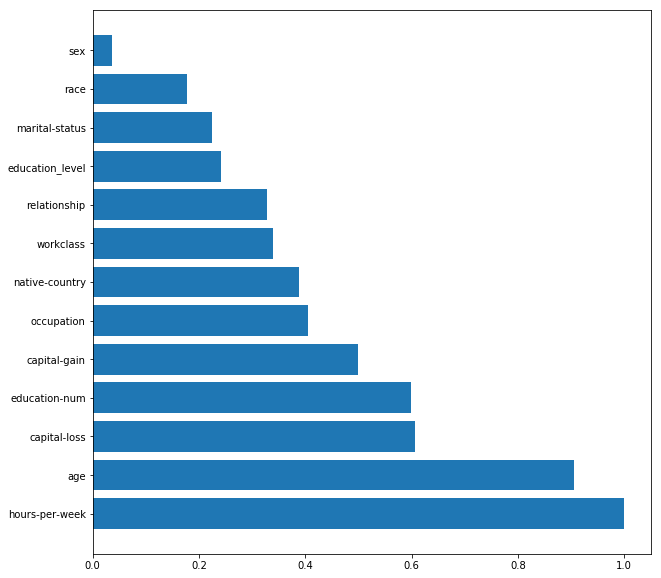

In [37]:
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),features[indices])
plt.show()

Individualmente, las variables que mas relevancia tienen a la hora de hacer la predicción son la **edad** y las **horas de trabajo a la semana**. Lo que no impide que pueda haber relaciones entre dos o mas variables que también sean relevantes.

Finalmente nos quedamos con el modelo **Boosted Trees** por haber obtenido los mejores resultados 